# Transect example for ICON CLM

This example uses a regional ICON model output for transect visualization.

We show you how to use the power of psyplot in visualizing unstructured grids to display vertically and horizontally unstructured data on its native grid for an interactive analysis.

**Notes:** 

- psy-transect is still under development. So please be cautios and let us know at https://github.com/psyplot/psy-transect/issues if you encounter any issues.
- you should run this notebook interactively. You can either do this on mybinder.org using the following button, or install the examples yourself from the [psy-transect branch of the psyplot examples](https://github.com/psyplot/examples/tree/psy-transect).
- if you run this example on mybinder or locally, you can also use the psyplot GUI. On mybinder, click [here](/desktop) and open the `Psyplot` desktop application. Then execute the following commands from the console in the GUI:

  ```
  cd ../transects
  run example_icon_clm.ipynb
  ```

**If you are running this example in a jupyter notebook, you should uncomment the following line to make it interactive.**

In [1]:
# uncomment the following line when running a jupyter notebook
# %matplotlib widget

In [2]:
import cartopy.crs as ccrs
import psyplot.project as psy
import matplotlib.pyplot as plt
import numpy as np
from psy_transect import utils

The first file contains a 4D-temperature for a region model on the ICON grid (triangular bounds for longitude and latitude). 

In [3]:
icon_ds = psy.open_dataset("data/icon_clm_demo.nc")
icon_ds.temp

<xarray.DataArray 'temp' (time: 1, height_2: 60, ncells: 17108)>
[1026480 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01
    clon      (ncells) float32 ...
    clat      (ncells) float32 ...
  * height_2  (height_2) float64 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0
Dimensions without coordinates: ncells
Attributes:
    standard_name:                air_temperature
    long_name:                    Temperature
    units:                        K
    param:                        0.0.0
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1
    institution:                  MPIMET

The vertical dimension (`height_2`) is a generic variable for vertical layers. They are not very informative for the visualization as one cannot infer from the dimension what level corresponds to what vertical height.

In [4]:
icon_ds.height_2

<xarray.DataArray 'height_2' (height_2: 60)>
array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60.])
Coordinates:
  * height_2  (height_2) float64 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0
Attributes:
    standard_name:  height
    long_name:      generalized_height
    axis:           Z
    bounds:         height_2_bnds

But we have the height information for the individual layers at the different positions available. Let's have a look:

In [5]:
orography = psy.open_dataset("data/icon_clm_orography.nc").psy.HHL
orography

<xarray.DataArray 'HHL' (height: 61, ncells: 17108)>
[1043588 values with dtype=float32]
Coordinates:
    clon     (ncells) float32 ...
    clat     (ncells) float32 ...
  * height   (height) float64 1.0 2.0 3.0 4.0 5.0 ... 57.0 58.0 59.0 60.0 61.0
Dimensions without coordinates: ncells
Attributes:
    standard_name:                altitude
    long_name:                    geometric height at half level center
    units:                        m
    CDI_grid_type:                unstructured
    number_of_grid_in_reference:  1
    cell_methods:                 time: point

Each grid cell in this `HHL` variable contains its altitude in metres. Note what we have 61 vertical layers in the `height` dimension of this file whereas the `height_2` dimension of the `temp` has 60 layers. This is because the `HHL` variable stores the upper and lower altitude of the individual grid cell at a given layer.

This is why the vertical dimension of `HHL` contains one more layer than `temp`. `psyplot` cannot handle this case. We can handle 3D coordinates, but we can not handle two different grids.

There are two transformations that we have to do:

1. we compute the mean of the orography levels to bring it to the same dimension of `height_2` and store it as a `coordinate` for `temp`, and
2. we use the `bounds` attribute from the CF-Conventions

`psy-transect` has a utility function that turns such a staggered grid into CF-conform bounds. You just give the variable that you want to transform, specify the name of the original dimension that you want to replace (`height`) and the name of the new dimension that you want to use `height_2`). Then you can optionally provide a dataset where we change the `coordinates` attribute accordingly.

In [6]:
new_ds = utils.mesh_to_cf_bounds(orography, "height", "height_2", icon_ds)

`new_ds` now has a `HHL` and a `HHL_bnds` coordinate.

In [7]:
new_ds

<xarray.Dataset>
Dimensions:        (bnds: 2, height_2: 60, ncells: 17108, time: 1, vertices: 3)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-01
    clon           (ncells) float32 -0.6416 -0.6749 -0.6503 ... 0.6921 0.7017
    clon_bnds      (ncells, vertices) float32 ...
    clat           (ncells) float32 1.256 1.25 1.251 ... 0.4118 0.4222 0.4435
    clat_bnds      (ncells, vertices) float32 ...
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 57.0 58.0 59.0 60.0
    height_2_bnds  (height_2, bnds) float64 ...
    HHL_bnds       (height_2, ncells, bnds) float32 nan nan ... 1.263e+03
    HHL            (height_2, ncells) float32 nan nan nan ... 831.8 1.273e+03
Dimensions without coordinates: bnds, ncells, vertices
Data variables:
    temp           (time, height_2, ncells) float32 ...
Attributes:
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    Conventions:          CF-1.6
    history:              Tue Jun 08 11:00:07 2021: cdo selname,temp icon_197...
    number_of_grid_used:  99
    uuidOfHGrid:          0fd960b5-09da-c2a1-3b03-710a726125a0
    uuidOfVGrid:          96fbc4ad-735b-2bb8-0ab9-982fffb12e60
    source:               git@gitlab.dkrz.de:icon/icon-nwp.git@5538446faa8884...
    institution:          Max Planck Institute for Meteorology
    title:                ICON simulation
    references:           see MPIM/DWD publications
    comment:              Burkhardt Rockel (g266006) on m11257 (Linux 2.6.32-...
    CDO:                  Climate Data Operators version 1.9.8 (https://mpime...

and this coordinate is also listed in the `coordinates` attribute of `temp`

In [8]:
new_ds.temp.encoding["coordinates"]

'HHL clat clon'

The last thing we have to do is a little fix to transform the `clat` and `clon` variables from `radians` to degrees.

In [9]:
new_ds["clon"] = new_ds.clon.copy(data=np.rad2deg(new_ds.clon))
new_ds["clat"] = new_ds.clat.copy(data=np.rad2deg(new_ds.clat))
new_ds["clon"].attrs["units"] = "degrees_east"
new_ds["clat"].attrs["units"] = "degrees_north"
new_ds["clat_bnds"] = new_ds.clat_bnds.copy(data=np.rad2deg(new_ds.clat_bnds))
new_ds["clon_bnds"] = new_ds.clon_bnds.copy(data=np.rad2deg(new_ds.clon_bnds))

encodings = {v: var.encoding for v, var in new_ds.variables.items()}
attrs = {v: var.attrs for v, var in new_ds.variables.items()}

new_ds = new_ds.where(new_ds.HHL.notnull().any("height_2"), drop=True)

for v, enc in encodings.items():
    new_ds[v].encoding.update(enc)

for v, att in attrs.items():
    new_ds[v].attrs.update(att)

And now we can create two plots. One is a horizontal transect at a given altitude, the second one is a vertical transect along a path.

We can connect them to each other. We connect the two axes to each other. You can draw a line with your mouse on the left map and this will update the vertical transect. And you can move the red line in the right plot to change the horizontal transect in the right plot.

/home/psommer/Documents/code/development/psyplot/psy-simple/psy_simple/plotters.py:3009: MatplotlibDeprecationWarning: 
The on_mappable_changed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use update_normal instead.
  mappable.changed()


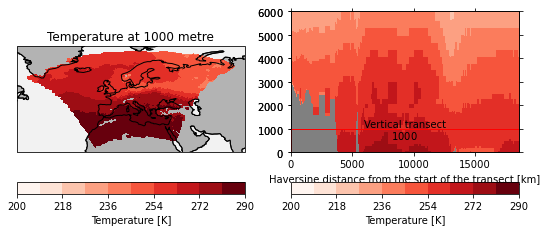

In [10]:
fig = plt.figure(figsize=(9, 3.7))

new_ds.psy.plot.horizontal_maptransect(
    name="temp", 
    decoder={"z": {"HHL"}},
    # we start with a transect at 1000m
    transect=1000,
    # display the variable name and chosen transect on the top of the map
    title="%(long_name)s at %(transect)1.0f metre",
    # some formatting things
    cmap="Reds",
    xgrid=False, ygrid=False,
    bounds=["rounded", 11, 5, 95],
    cticks=["bounds", 2],
    clabel="{desc}",
    lsm={"ocean": "0.95", "land": "0.7", "coast": "k"},
    # datagrid="k-",  # you can uncomment this to see the unstructured horizontal grid
    # create a new subplot for this map in our figure
    ax=fig.add_subplot(121, projection=ccrs.PlateCarree()),
    clear=True,
)

new_ds.psy.plot.vertical_maptransect(
    name="temp",
    decoder={"z": {"HHL"}},
    # as we use unstructed data here, we should specify the minimum resolution for the
    # transect in the units of coordinates (here 0.1 degrees)
    transect_resolution=0.1,
    # we use the haversine distance for cells along the transect for the
    # x-axis
    coord="haversine",
    # color for the background of the plot. This will show mountaineous areas for instance.
    background="0.5",
    # datagrid="k-",  # you can uncomment this to see the unstructured vertical grid
    xlim="minmax",
    xlabel="{desc}",
    clabel="{desc}",
    ylim=(0, 6000),
    yticks=np.linspace(0, 6000, 7),
    ax=fig.add_subplot(122),
)

# now we connect the two plots such that you can move the line of the right
# plot to update the map, and draw a line on the map to update the vertical
# transect
p1, p2 = psy.gcp(True).plotters[-2:]
p1.connect_ax(p2.ax)
p2.connect_ax(p1.ax)
p1.share(p2, ["colors", "cticklabels", "cticks"])
p2.update(ylim=p2.ylim.value, yticks=p2.yticks.value, force=True)